# MCT4052 Workshop 7a: Posture Recognition

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to use a classifier to recognize specific postures from motion related data. In particular we use 3-axis accelerometer data from a hand-held smartphone. We used [oscHook](https://play.google.com/store/apps/details?id=com.hollyhook.oscHook&hl=en&gl=US) on Android sending data at a rate of 50 Hz (fastest option).

OSC data from the phone was collected uwing the PD patch *notebooks/utilities/OSChookToTxt.pd*. The patch collect the accelerometer (used) and linear acceleration data (unused) in a text file. Mind that for back compatibility reasons, in the oscHook v2 application we have set 'Data range' and 'Output range' to [-10;10] for both accelerometer and linear acceleration. If you are using oscHook v1 you have to rename 'accelerometer' to 'gravity' in the OSC prefix of the third cell of this notebook.

The data from the text files was imported to an .xlsx file, which was then exported as a posture.csv file. The latter is imported here in the notebook using Pandas. The data in postures.csv represents approximately 1.5 minutes of motion data, including four diferent postures, each held for a few seconds seconds in two separate instances. The postures are (with hand-held smartphone):
1. arm lifted up
2. arm on the side with phone facing up
2. arm on the side with phone facing down
4. arm down in rest position

The exact starting and ending indexes of the postures was manually found by investigating the axxelerometer data waveforms (displayed below). The various postures were labeled with integers identical to the previous list, while the remaining data, representing motion in other positions was labeled as 'other' (assigned to integer 0).

We use this data to train a simple SVM classifier. Scaling is not necessary (although it can be applied) as the data across the the three axis xyz is already consistent (i.e. similar range). Also, dimensionality reduction is no necessary as we have only 3 features.

We still partition the data in train/test splits and assess the performance of the classifier. However, in this context, if we understand that a system designed as such is performing well, we can use the entire dataset for training since we will later use it with real-time motion data.

When the classifier is ready, we use to classify data in real-time by receiving OSC packates through a [python-osc](https://pypi.org/project/python-osc/) server. The system simply prints on screen the label of the recognized posture. This can be be formatted and forwarded via OSC to another system to trigger notes, scenes, present, sequences, or drive any other discrete music-related control. Given the relative low rate at which accelerometer data is read (50Hz) and the small size of the SVM classifier, the system can easily satisfy the real-time constraints also on non real-time platforms (i.e. general purpos OS and Python).

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn import *
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
from IPython.display import clear_output, display

### 1. Importing the data, creating labels and training the classifier

If we analyze the misclassified data is composed mostly by 'other' examples. Rather than a limitation of the classifier this appears to be a limitation of the way the data was generated. We can't excluded that in the 'other' segments we acidentally generated momentary data matching one of the four postures.


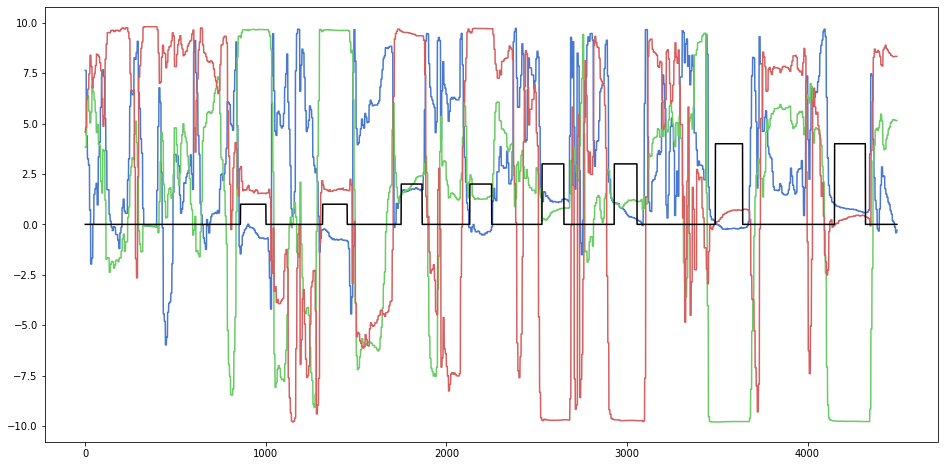

Number of mislabeled samples 38 out of 450
Accuracy: 0.9155555555555556
misclassifieds: 
other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other other 

In [2]:
#read dataset
dataset = pd.read_csv('./data/examples10/postures.csv')

#importing the columns with accelerometer (gravity) data on the three exis
rawdata = dataset[['grx', 'gry', 'grz']].to_numpy()
labels = np.zeros(rawdata.shape[0])

#creating list of text labels
classes = ['other', 'arm up', 'arm side face up', 'arm side face down', 'arm down']

#iterating through the entries of the dataset and creating associated labels
#the index edges for the postures have been found manually by visually inspecting the waveforms
for i in range(0,rawdata.shape[0]):
    if (860 <= i <= 1000) or (1315 <= i <= 1450):
        labels[i] = classes.index('arm up')
    elif (1750 <= i <= 1865) or (2130 <= i <= 2250):
        labels[i] = classes.index('arm side face up')
    elif (2530 <= i <= 2650) or (2930 <= i <= 3055):
        labels[i] = classes.index('arm side face down')
    elif (3490 <= i <= 3640) or (4150 <= i <= 4320):
        labels[i] = classes.index('arm down')
    else:
        labels[i] = classes.index('other')

plt.figure(figsize=(16, 8))
plt.plot(rawdata)
plt.plot(labels,'k')
#plt.plot((-1)*labels,'k') #uncomment this line to have a symmetric visual representation porsture-areas
plt.show()

#creating train/test split
rawdata_train, rawdata_test, lab_train, lab_test = sklearn.model_selection.train_test_split(rawdata, labels, test_size=0.1)

#training the model
svm = sklearn.svm.SVC(kernel='linear', C=1)
svm.fit(rawdata_train, lab_train)

#applying the the model on the test data (features)
lab_predict =  svm.predict(rawdata_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

errors = lab_test != lab_predict
print("misclassifieds: ")
for i in range(0,len(errors)):
    if errors[i] == True:
        print(classes[int(lab_test[i])], end = ' ')

### 2. Using the classifier with OSC real-time data

Here we use the classifier we previously trained. For a standalone application it would be more suitable to load the svm model from a file (i.e. perform the training once for all and store it in a file).

The following cell will run until you press the stop button. However, before you can run it again you need to close the OSC server running the following cell.

In [ ]:
from pythonosc import dispatcher
from pythonosc import osc_server

acc_vect = np.zeros((1,3))

#creating a function that will handle and classify accelerometer data
def acceleration_vector(address, args):
    #print(address)
    #print(args)
    if address.find('accelerometer/x') != -1:
        acc_vect[0,0] = args
    elif address.find('accelerometer/y') != -1:
        acc_vect[0,1] = args
    elif address.find('accelerometer/z') != -1:
        acc_vect[0,2] = args
        clear_output(wait=True)
        pred = svm.predict(acc_vect)
        print(classes[int(pred)])

#attaching the function to the dispatcher
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/accelerometer/*", acceleration_vector)

#starting the OSC server
server = osc_server.ThreadingOSCUDPServer(('0.0.0.0', 8001), dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()

In [ ]:
#closing the OSC server
server.server_close()

### 3. Follou-up activity

1. Create your dataset and use it to train the system.
2. If you find the system response too sensitive, try to widen a bit the edges of te posture regions, or add a bit of white noise to the posture training data.